# preparations

## install Qiskit

In [1]:
%pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 14.5 MB/s eta 0:00:00


## loading necessary libraries

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, execute, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.quantum_info import Statevector, DensityMatrix

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

## noise models:

### IonQ's Aria specifications:
depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for $t$

In [3]:
# error probabilities
p_meas = 3.9e-3
p_reset = 3.9e-3
p_gate1 = 6e-4
p_gate2 = 6e-3

# thermal relaxation error (nanosecond time)
T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = np.random.choice(range(600, 700), 10, replace=False)
time_u1 = 0 # virtual gate
time_gate1 = 135e3 # u1 and u2
time_gate2 = 600e3 # 2 qubit gate

# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

# creating the noise model
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

### IonQ's Harmony specifications:

(it's basically all noise compared to Aria)

In [4]:
h_p_meas = 1.8e-3
h_p_reset = 1.8e-3
h_p_gate1 = 4e-3
h_p_gate2 = 2.7e-2

# thermal relaxation error (nanosecond time)
h_T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
h_T2 = 1e9

h_time_meas = np.random.choice(range(600, 700), 10, replace=False) # assumed same as aria
h_time_u1 = 0 # virtual gate?
h_time_gate1 = 1e4 # u1 and u2
h_time_gate2 = 2.1e5 # 2 qubit gate

# thermal relaxation error
h_ther_u1  = [thermal_relaxation_error(t1 * 1e9, h_T2, h_time_u1)
              for t1 in h_T1s]
h_ther_gate1  = [thermal_relaxation_error(t1 * 1e9, h_T2, h_time_gate1)
              for t1 in h_T1s]
h_ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, h_T2, h_time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, h_T2, h_time_gate2))
              for t1a in h_T1s]
               for t1b in h_T1s]

# depolarizing error
h_dep_reset = depolarizing_error(h_p_reset, 1)
h_dep_gate1 = depolarizing_error(h_p_gate1 - 9.99995e-6, 1)
h_dep_gate2 = depolarizing_error(h_p_gate2 - 2.09977952e-4, 2)

# readout error
h_er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

fake_harmony = NoiseModel()

for j in range(10):
    fake_harmony.add_quantum_error(h_ther_u1[j].compose(h_dep_gate1), "u1", [j])
    fake_harmony.add_quantum_error(h_ther_gate1[j].compose(h_dep_gate1), "u2", [j])
    fake_harmony.add_quantum_error(h_ther_gate1[j].compose(h_dep_gate1), "u3", [j])
    for k in range(10):
        fake_harmony.add_quantum_error(h_ther_gate2[j][k].compose(h_dep_gate2), "cx", [j, k])
fake_harmony.add_all_qubit_quantum_error(h_dep_reset, "reset")
fake_harmony.add_all_qubit_readout_error(h_er_meas)

## miscellaneous

### Grover parameter finder: this optimizes `delta` $\in (0, 1)$ so that the query complexity is minimal for a given pair of target probability and ratio, `P` and `Lambda`

note #1: for target probability $\sim$ 90%, it helps as long as `Lambda` $\gg$ `1e-4`

note #2: there ought to be a simpler, analytic version of this

In [5]:
def Chebyshev(x: float, L:  float):
    return np.cos(L * np.arccos(x)) if x <= 1 else np.cosh(L * np.arccosh(x))

def GroverParameterOptimizer(P: float, Lambda: float, N: int):
    step, L, p = pow(2, - N), 0, 0
    done = False
    while p < P:
        L += 1
        delta = step
        l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        while l > L:
            delta += step
            l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        candidate = delta
        while delta < 1:
            p_new = 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)
            if p_new >= p:
                p = p_new
                candidate = delta
            delta += step
            l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1

    delta = candidate
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
    p = 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)

    return delta, l, p

### graph plotter

In [6]:
def createGraph(GraphLaplacian: list[list[int]]):
    Edges = []
    for i, row in enumerate(GraphLaplacian):
        for j, v in enumerate(row[:i]):
            if v == - 1:
                Edges.append([i, j])
    Graph = nx.Graph()
    Graph.add_edges_from(Edges)
    nx.draw_networkx(Graph)

# Grover Fixed Point Search for gerenal Quadratic Binary Optimization problems

In [19]:
def GroverForQUBO(QuadraticForm: list[list[int]], digits: int, threshold: int, delta: float, Lambda: float, noise: bool):

    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
    gamma = 1 / np.sqrt(1 - pow(np.cosh(np.arccosh(1 / delta) / (2 * l + 1)), - 2))
    angles = [2 * np.arctan(gamma / np.tan(2 * np.pi * j / (2 * l + 1))) for j in range(1, l + 1)]

    # one quantum register for each vertex
    QRegX = QuantumRegister(len(QuadraticForm), "x")

    # quantum registers to digitize cut values
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegX[:] + QRegY[:])

    # adding threshold-1-(sum(Q)+trace(Q))/4 to the anicillas + moving phase here from QFT; this could have gone into HalfCostOracle, but this it's cheaper this way
    theta = (threshold - 1/2 - (QuadraticForm.sum() + np.trace(QuadraticForm))/4) * np.pi
    for i, q in enumerate(reversed(QRegY)):
        QC.rz(theta - np.pi/2, q)
        theta /= 2

    for alpha, beta in zip(angles, reversed(angles)):

        # S_t (beta)
        for i, p in enumerate(QRegX):

            if np.sum(QuadraticForm[i]) != 0:
                theta = np.sum(QuadraticForm[i]) * np.pi
                for q in reversed(QRegY):
                    theta /= 2
                    QC.rz(- theta, p)
                    QC.cx(q, p)
                    QC.rz(theta, p)
                    QC.cx(q, p)

            for j, r in enumerate(QRegX[i + 1:]):
                if QuadraticForm[i][i + 1 + j] != 0:
                    QC.cx(p, r)
                    theta = QuadraticForm[i][i + 1 + j] * np.pi
                    for q in reversed(QRegY):
                        theta /= 2
                        QC.rz(theta, r)
                        QC.cx(q, r)
                        QC.rz(- theta, r)
                        QC.cx(q, r)
                    QC.cx(p, r)

        for i, q in enumerate(reversed(QRegY)):
            theta = np.pi / 2
            for r in QRegY[len(QRegY) - i:]:
                theta /= 2
                QC.cx(r, q)
                QC.rz(theta, q)
                QC.cx(r, q)
            QC.h(q)

        QC.rz(beta, QRegY[0])

        for i, q in enumerate(QRegY):
            QC.h(q)
            theta = np.pi / 2
            for r in QRegY[i+1:]:
                theta /= 2
                QC.cx(r, q)
                QC.rz(- theta, q)
                QC.cx(r, q)

        for i, p in enumerate(reversed(QRegX)):

            for j, r in enumerate(reversed(QRegX[len(QRegX) - i:])):
                if QuadraticForm[- i - 1][- j - 1] != 0:
                    QC.cx(p, r)
                    theta = QuadraticForm[- i - 1][- j - 1] * np.pi
                    for q in reversed(QRegY):
                        theta /= 2
                        QC.cx(q, r)
                        QC.rz(theta, r)
                        QC.cx(q, r)
                        QC.rz(- theta, r)
                    QC.cx(p, r)

            if np.sum(QuadraticForm[- i - 1]) != 0:
                theta = np.sum(QuadraticForm[- i - 1]) * np.pi
                for q in reversed(QRegY):
                    theta /= 2
                    QC.cx(q, p)
                    QC.rz(- theta, p)
                    QC.cx(q, p)
                    QC.rz(theta, p)

        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        QC.mcp(alpha, QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.h(QRegX)

    if noise:
        QC.save_density_matrix(qubits=QRegX,
                               label=f"rho")
        simulator = AerSimulator(method="density_matrix",
                                 noise_model=fake_aria)
                                 #noise_model=fake_harmony)
        QC = transpile(circuits=QC,
                       backend=simulator,
                       optimization_level=3)
        psi = simulator.run(QC, shots=1).result().data()["rho"].probabilities()
    else:
        QC.save_statevector()
        simulator = AerSimulator(method="statevector")
        psi = Statevector(execute(QC, simulator).result().get_statevector()).probabilities(np.arange(len(QRegX)))

    return psi

# parameters & testing for MaxCut:

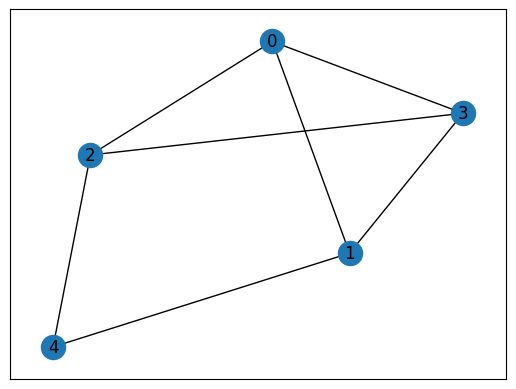

In [9]:
# graph size
NumberOfVerticies = 5 # must be <= 17 to fit in Aria
edge_probability = 5e-1

# random, connected graph
disconnected = True
while disconnected:
    GraphLaplacian = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
    for i in range(NumberOfVerticies):
        for j in range(i + 1, NumberOfVerticies):
            if np.random.rand() < edge_probability:
                GraphLaplacian[i][j] = GraphLaplacian[j][i] = - 1
        GraphLaplacian[i][i] = - np.sum(GraphLaplacian[i])
    disconnected = (NumberOfVerticies != np.linalg.matrix_rank(GraphLaplacian) + 1)

NumberOfEdges = np.trace(GraphLaplacian) >> 1

# Erdos-Edwards bound for connected graphs
ErdosEdwards = int(np.ceil((2 * NumberOfEdges + NumberOfVerticies - 1)/4))

createGraph(GraphLaplacian)

# let's get rid of the vertex with the highest degree
maxdeg = [0, 0]
for i in range(NumberOfVerticies):
    if GraphLaplacian[i][i] > maxdeg[1]:
        maxdeg = [i, GraphLaplacian[i][i]]
if maxdeg[0] + 1 != NumberOfVerticies:
    GraphLaplacian[[maxdeg[0], -1], :] = GraphLaplacian[[-1, maxdeg[0]], :]
    GraphLaplacian[:, [maxdeg[0], -1]] = GraphLaplacian[:, [-1, maxdeg[0]]]

Q = GraphLaplacian[np.ix_(np.arange(NumberOfVerticies - 1), np.arange(NumberOfVerticies - 1))]


# cut-function and MaxCut
cuts = {}
for x in range(1 << (NumberOfVerticies - 1)):
    conf = np.array([(x >> i)&1 for i in range(NumberOfVerticies - 1)])
    cuts[x] = np.matmul(conf, np.matmul(Q, np.transpose(conf)))
MaxCut = max(cuts.values())

# cut disctibution and ratios
random_chance = {i: 0 for i in range(MaxCut + 1)}
#for i in range(MaxCut + 1):
#    random_chance[i] = 0

Lambda = 0
dp = pow(2, 1 - NumberOfVerticies)
for x in range(1 << (NumberOfVerticies - 1)):
    random_chance[cuts[x]] += dp
    if cuts[x] >= ErdosEdwards:
        Lambda += dp

threshold = ErdosEdwards

m, sigma = np.trace(GraphLaplacian) / 4, 0
for cut in random_chance:
    sigma += pow(cut - m, 2) * random_chance[cut]

sigma = np.sqrt(sigma)

digits = 1 + int(np.ceil(np.log2(max(threshold, NumberOfEdges + 1 - threshold)))) if NumberOfVerticies > 2 else 2

In [16]:
P = 0.9 # lower bound for the target probability
delta, l, prob = GroverParameterOptimizer(P, Lambda, 10)
print(f"MaxCut\tthreshold\tLambda\ttarget probability\tdelta\tl\tdigits\n{MaxCut}\t{threshold}\t\t{np.round(Lambda, 2)}\t{prob:.2%}\t\t\t{np.round(delta, 2)}\t{l}\t{digits}")

MaxCut	threshold	Lambda	target probability	delta	l	digits
6	5		0.19	92.72%			0.9	1	4


### simulation:

In [20]:
noise = True
#noise = False

print(f"\ncomputation with Grover Fixed Point Search...\n")
start_time = time.time()
psi = GroverForQUBO(Q, digits, threshold, delta, Lambda, noise)
end_time = time.time()
print(f"done in {np.round(end_time - start_time, 2)} seconds\n")


computation with Grover Fixed Point Search...

done in 4.12 seconds



In [21]:
s = f"simulation with noise\n" if noise else f"simulation without noise\n"
s += f"\nthe graph:\n----------\nMaxCut\t\t\t= {MaxCut}\nnumber of edges\t\t= {NumberOfEdges}\nErdős-Edwards bound\t= {ErdosEdwards}\nthreshold\t\t= {threshold} ({threshold/MaxCut:.1%} of Maxcut)\n\nthe graph Laplacian:\n--------------------\n\n"
for row in GraphLaplacian:
    s += f"{row.view()}\n"
s += f"\nGrover parameters:\n------------------\nLambda\t= {np.round(Lambda, 2)}\ndelta\t= {np.round(delta, 2)}\nl\t= {l}\n\nresults with Grover:\n--------------------\n\n"

distribution = {}
for i in range(MaxCut + 1):
    distribution[i] = 0

M = success = 0
for x, p in enumerate(psi):
    distribution[cuts[x]] += p
    M += cuts[x] * p
    if cuts[x] >= threshold:
        success += p

var = 0
for cut in distribution:
    var += pow(cut - M, 2) * distribution[cut]
var = np.sqrt(var)

sign_m = "+" if M >= m else "-"
sign_sigma = "+" if var >= sigma else "-"

difference = {}
for cut in range(MaxCut + 1):
    difference[cut] = distribution[cut] - random_chance[cut]

s += f"expectation\t= {np.round(M, 2)}\t({m} {sign_m} {np.round(abs(M - m), 2)})\nvariance\t= {np.round(var, 2)}\t({np.round(sigma, 1)} {sign_sigma} {np.round(abs(var - sigma), 2)})\n\nsuccess probability = {success:.2%} (theoretical value = {prob:.2%}, random chance = {Lambda:.2%})\n"

print(s)

simulation with noise

the graph:
----------
MaxCut			= 6
number of edges		= 7
Erdős-Edwards bound	= 5
threshold		= 5 (83.3% of Maxcut)

the graph Laplacian:
--------------------

[ 2 -1 -1  0  0]
[-1  3  0 -1 -1]
[-1  0  3 -1 -1]
[ 0 -1 -1  3 -1]
[ 0 -1 -1 -1  3]

Grover parameters:
------------------
Lambda	= 0.19
delta	= 0.9
l	= 1

results with Grover:
--------------------

expectation	= 4.2	(3.5 + 0.7)
variance	= 1.45	(1.3 + 0.13)

success probability = 51.32% (theoretical value = 92.72%, random chance = 18.75%)



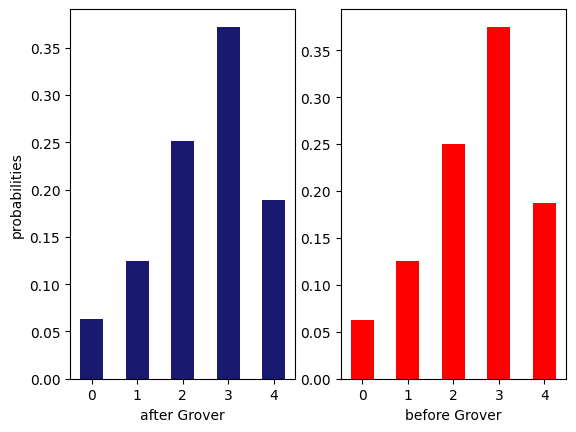

In [241]:
fig, axs = plt.subplots(1, 2)

axs[0].bar(distribution.keys(),
              distribution.values(),
              width=0.5,
              color="midnightblue",
              tick_label=[i for i in range(MaxCut + 1)])
axs[0].set(xlabel=f"after Grover", ylabel=f"probabilities")

axs[1].bar(distribution.keys(),
              random_chance.values(),
              width=0.5,
              color="red",
              tick_label=[i for i in range(MaxCut + 1)])
axs[1].set(xlabel=f"before Grover")

plt.show()

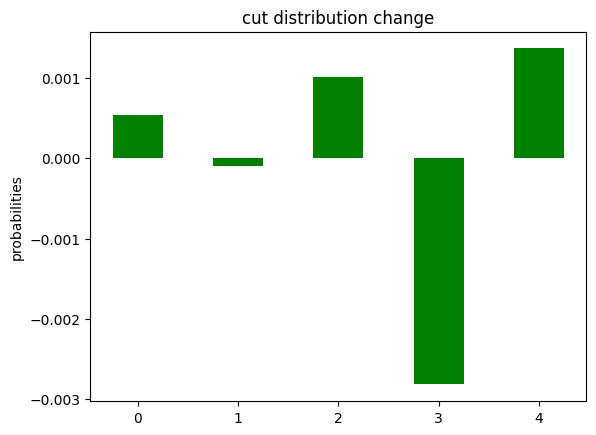

In [242]:
plt.bar(difference.keys(),
        difference.values(),
        width=0.5,
        color="green",
        tick_label=[i for i in range(MaxCut + 1)])
plt.title(f"cut distribution change")
plt.ylabel(f"probabilities")
plt.show()

## portfolio optimization

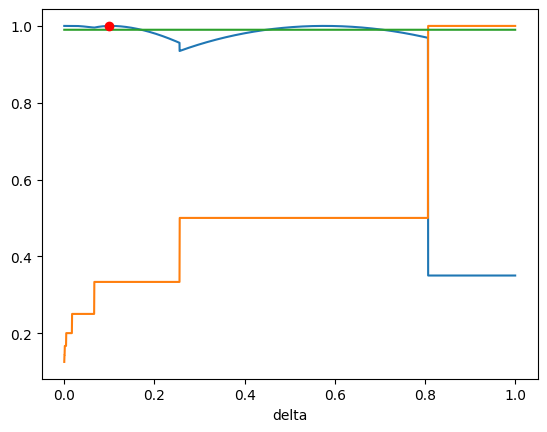

In [ ]:
Lambda = 3.5e-1
N = 12
step = pow(2, - N)
prob = 0.99

deltas = np.arange(step, 1 - step, step, dtype=float)
P = np.zeros(len(deltas), dtype=float)

simplicity = np.ones(len(deltas), dtype=float)
treshold = prob * np.ones(len(deltas), dtype=float)

for i, delta in enumerate(deltas):
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
    simplicity[i] = 1/(l+1)
    P[i] = Lambda if l == 0 else 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)

plt.xlabel(f"delta")
plt.plot(deltas,P)
plt.plot(deltas,simplicity)
plt.plot(deltas,treshold)
l_Y = int(np.ceil(np.arccosh(1 / np.sqrt(1-prob)) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
delta_Y = np.sqrt(1-prob)
plt.plot(delta_Y, 1 - pow(delta_Y * Chebyshev(Chebyshev(1 / delta_Y, 1 / (2 * l_Y + 1)) * np.sqrt(1 - Lambda), 2 * l_Y + 1), 2), "ro")
plt.show()

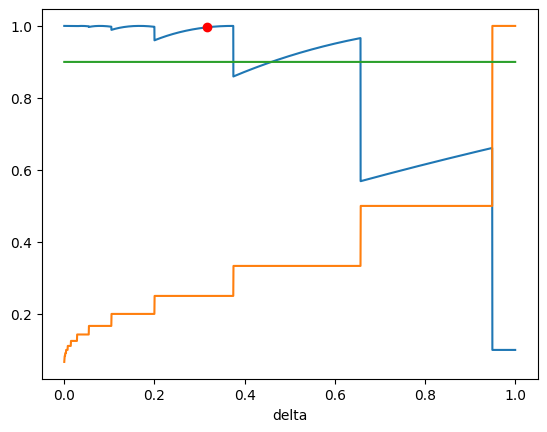

In [ ]:
Lambda = 1e-1
N = 12
step = pow(2, - N)
prob = 0.9

deltas = np.arange(step, 1 - step, step, dtype=float)
P = np.zeros(len(deltas), dtype=float)

simplicity = np.ones(len(deltas), dtype=float)
treshold = prob * np.ones(len(deltas), dtype=float)

for i, delta in enumerate(deltas):
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
    simplicity[i] = 1/(l+1)
    P[i] = Lambda if l == 0 else 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)

plt.xlabel(f"delta")
plt.plot(deltas,P)
plt.plot(deltas,simplicity)
plt.plot(deltas,treshold)
l_Y = int(np.ceil(np.arccosh(1 / np.sqrt(1-prob)) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
delta_Y = np.sqrt(1-prob)
plt.plot(delta_Y, 1 - pow(delta_Y * Chebyshev(Chebyshev(1 / delta_Y, 1 / (2 * l_Y + 1)) * np.sqrt(1 - Lambda), 2 * l_Y + 1), 2), "ro")
plt.show()

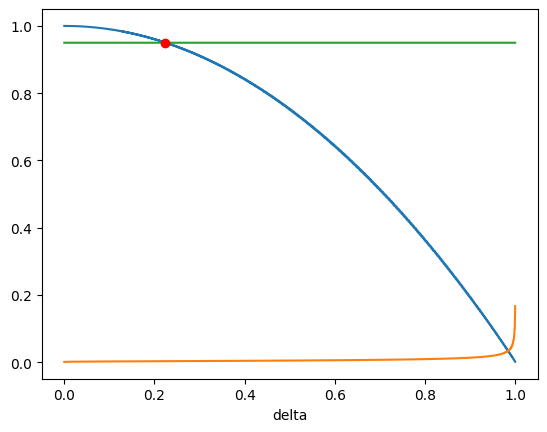

In [ ]:
Lambda = 1e-5
N = 12
step = pow(2, - N)
prob = 0.95

deltas = np.arange(step, 1 - step, step, dtype=float)
P = np.zeros(len(deltas), dtype=float)

simplicity = np.ones(len(deltas), dtype=float)
treshold = prob * np.ones(len(deltas), dtype=float)

for i, delta in enumerate(deltas):
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
    simplicity[i] = 1/(l+1)
    P[i] = Lambda if l == 0 else 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)

plt.xlabel(f"delta")
plt.plot(deltas,P)
plt.plot(deltas,simplicity)
plt.plot(deltas,treshold)
l_Y = int(np.ceil(np.arccosh(1 / np.sqrt(1-prob)) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
delta_Y = np.sqrt(1-prob)
plt.plot(delta_Y, 1 - pow(delta_Y * Chebyshev(Chebyshev(1 / delta_Y, 1 / (2 * l_Y + 1)) * np.sqrt(1 - Lambda), 2 * l_Y + 1), 2), "ro")
plt.show()